In [1]:
# google colab file upload
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving seq_click_1636895240.npy to seq_click_1636895240.npy
Saving seq_none_1636895240.npy to seq_none_1636895240.npy
User uploaded file "seq_click_1636895240.npy" with length 31728128 bytes
User uploaded file "seq_none_1636895240.npy" with length 31968128 bytes


In [2]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [4]:
actions = [
    'none',
    'click'
]

data = np.concatenate([
    np.load('seq_none_1637733510.npy'),
    np.load('seq_click_1637733510.npy')
], axis=0)

data.shape

(2654, 30, 100)

In [5]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(2654, 30, 99)
(2654,)


In [6]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(2654, 2)

In [7]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=2021) # train 8 : test 2

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(2123, 30, 99) (2123, 2)
(531, 30, 99) (531, 2)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                41984     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 44,130
Trainable params: 44,130
Non-trainable params: 0
_________________________________________________________________


In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
64/67 [===========================>..] - ETA: 0s - loss: 31.7332 - acc: 0.6323
Epoch 00001: val_acc improved from -inf to 0.56686, saving model to models/model.h5
67/67 [==============================] - 3s 24ms/step - loss: 33.3265 - acc: 0.6317 - val_loss: 94.8204 - val_acc: 0.5669 - lr: 0.0010
Epoch 2/200
66/67 [============================>.] - ETA: 0s - loss: 107.7552 - acc: 0.5279
Epoch 00002: val_acc improved from 0.56686 to 0.60640, saving model to models/model.h5
67/67 [==============================] - 1s 20ms/step - loss: 107.3596 - acc: 0.5285 - val_loss: 31.1081 - val_acc: 0.6064 - lr: 0.0010
Epoch 3/200
64/67 [===========================>..] - ETA: 0s - loss: 11.4376 - acc: 0.6675
Epoch 00003: val_acc improved from 0.60640 to 0.75895, saving model to models/model.h5
67/67 [==============================] - 1s 20ms/step - loss: 11.0709 - acc: 0.6736 - val_loss: 3.9058 - val_acc: 0.7589 - lr: 0.0010
Epoch 4/200
67/67 [==============================] - ETA: 0s - 

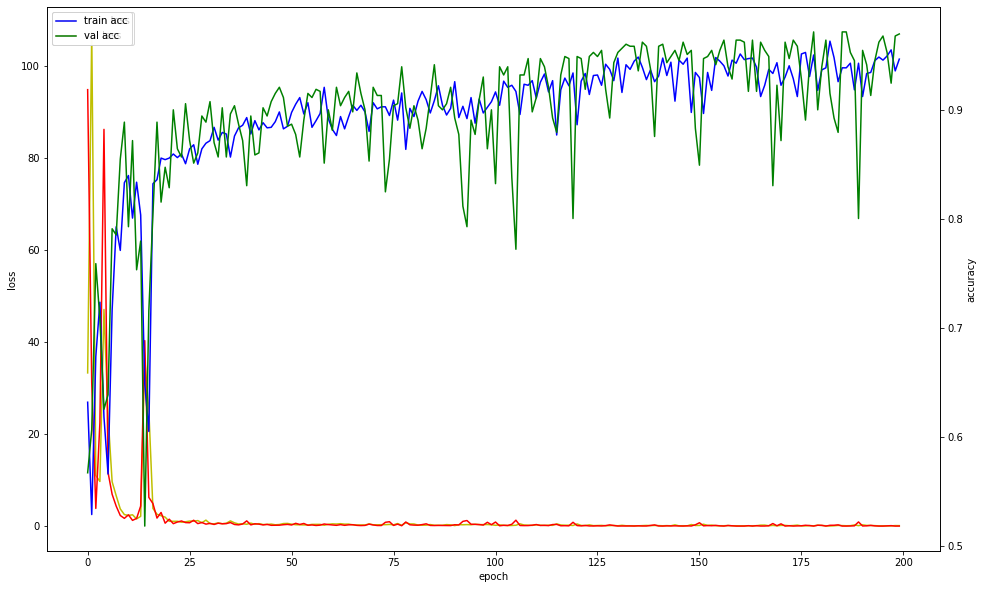

In [10]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [11]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

array([[[259,   9],
        [  6, 257]],

       [[257,   6],
        [  9, 259]]])

In [12]:
result = model.evaluate(x_val, y_val, batch_size=100)
print('loss :', result[0])
print('test accuracy :', result[1])

6/6 [==============================] - 0s 13ms/step - loss: 0.0748 - acc: 0.9718
loss : 0.07482842355966568
test accuracy : 0.9717513918876648


In [15]:
!pip install tensorflowjs


     |█████                           | 10 kB 24.2 MB/s eta 0:00:01
     |██████████▏                     | 20 kB 30.5 MB/s eta 0:00:01
     |███████████████▎                | 30 kB 23.9 MB/s eta 0:00:01
     |████████████████████▎           | 40 kB 18.7 MB/s eta 0:00:01
     |█████████████████████████▍      | 51 kB 8.9 MB/s eta 0:00:01
     |██████████████████████████████▌ | 61 kB 9.1 MB/s eta 0:00:01
     |████████████████████████████████| 64 kB 2.2 MB/s 


In [17]:
# h5 python model -> tfjs json model
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, 'models')